# Shapley, SVETA and SHAP values for a model system of low dimensionality.

In [1]:
from src.sverad import sverad_f_plus, sverad_f_minus, ExactRBFShapleyComputation
from src.utils import set_seeds

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
import pandas as pd
import pickle
from scipy.stats import pearsonr
from shap import KernelExplainer
from tqdm.auto import tqdm
import warnings

import numpy as np

In [2]:
SEED = 42
set_seeds(SEED)

COMPUTE_RANDOM_VECTORS = True
SAVE_EXPLANATIONS = True

## Generating random vectors.

In [3]:
# Initializing the random generator
r_gen = default_rng(SEED)

In [4]:
random_vectors = r_gen.integers(0,2,(20,15))
# random_vectors_sparse = sparse.csr_matrix(random_vectors)
# sim_mat = tanimoto_similarity_sparse(random_vectors_sparse, random_vectors_sparse)

## Generating SVs, SVERAD values and SHAP values.
For all pairs SHAP SVETA and SVs are calculated and compared.

In [5]:
save_path = "./data/pickle/explanations_random_vectors.p"
if COMPUTE_RANDOM_VECTORS:
    explanation_df = []
    # Iterating over all pairs
    for i, vector_i in tqdm(enumerate(random_vectors), total=20):
        exact_shapley_gen_i = ExactRBFShapleyComputation(vector_i)
        for j, vector_j in tqdm(enumerate(random_vectors), total=20):
            shapley_ij = exact_shapley_gen_i.shapley_values(vector_j)

            intersection_ij = vector_i * vector_j  # Vector where intersecting features are set to 1
            union_ij = 1 - (1-vector_i) * (1-vector_j)  # Vector where features of the union are set to 1
            diff_ij = union_ij - intersection_ij  # Vector where features from the symmetric difference are set to 1
            
            num_intersecting_features = sum(intersection_ij)
            num_difference_features = sum(diff_ij)

            sverad_value_f_plus_ij = sverad_f_plus(num_intersecting_features, num_difference_features)
            sverad_value_f_minus_ij = sverad_f_minus(num_intersecting_features, num_difference_features)

            sverad_values_ij = intersection_ij * sverad_value_f_plus_ij + diff_ij * sverad_value_f_minus_ij

            # Mask to get the 18 other vectors which are not i or j as background.
            mask_background_sample = np.ones(20, dtype=bool)
            mask_background_sample[i] = False
            mask_background_sample[j] = False
            with warnings.catch_warnings():
                # ignore all caught warnings
                warnings.filterwarnings("ignore")
                explainer_vec_i = KernelExplainer(exact_shapley_gen_i.rbf_kernel_value, random_vectors[mask_background_sample])
                shap_ij = explainer_vec_i.shap_values(vector_j)

            explanation_df.append({"instance a": i,
                                   "instance b": j,
                                   "Shapley": shapley_ij,
                                   "SVERAD": sverad_values_ij,
                                   "SHAP": shap_ij,
                                   "SHAP_expected_value": explainer_vec_i.expected_value[0],
                                   })
            
        #break # TEST ONLY ONE INSTANCE for testing
    explanation_df = pd.DataFrame(explanation_df)

    if SAVE_EXPLANATIONS:
        with open(save_path, "wb") as outfile:
            pickle.dump(explanation_df, outfile)
else:
    print("Loading precomputed explanations")
    with open(save_path, "rb") as infile:
        explanation_df = pickle.load(infile)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

#### Pearson r correlation coefficients

In [ ]:
corr_df = []
for i, row in explanation_df.iterrows():
    if row["instance a"] == row["instance b"]:
        continue
    shapley_exact = row["Shapley"]
    sverad_value = row["SVERAD"]
    assert all(np.isclose(shapley_exact, sverad_value, 0, 1e-10))
    shap = row["SHAP"][0]
    
    corr_sverad_SV, p_sverad_SV = pearsonr(sverad_value, shapley_exact)
    corr_sverad_SHAP, p_sverad_SHAP = pearsonr(sverad_value, shap)
    corr_SHAP_SV, p_SHAP_SV = pearsonr(shapley_exact, shap)

    corr_df.append({"a": row["instance a"], "b": row["instance b"], "Correleation SVERAD - Exact SV": corr_sverad_SV, "Correlation SVERAD - SHAP": corr_sverad_SHAP, "correlation SHAP - Exact SV": corr_SHAP_SV})
corr_df = pd.DataFrame(corr_df)
display(corr_df)
display(corr_df.mean())

,a,b,Correleation SVERAD - Exact SV,Correlation SVERAD - SHAP,correlation SHAP - Exact SV
0,0,1,1.0,0.773915,0.773915
1,0,2,1.0,0.581958,0.581958
2,0,3,1.0,0.806941,0.806941
3,0,4,1.0,0.342768,0.342768
4,0,5,1.0,0.625114,0.625114
5,0,6,1.0,0.884593,0.884593
6,0,7,1.0,0.382298,0.382298
7,0,8,1.0,0.954530,0.954530
8,0,9,1.0,0.760730,0.760730
9,0,10,1.0,0.808722,0.808722


a                                  0.000000
b                                 10.000000
Correleation SVERAD - Exact SV     1.000000
Correlation SVERAD - SHAP          0.698322
correlation SHAP - Exact SV        0.698322
dtype: float64

#### Old code below

In [ ]:
corr_df = []
for i, row in explanation_df.iterrows():
    if row["instance a"] == row["instance b"]:
        continue
    shapley_exact = row["Shapley"]
    sverad_value = row["SVERAD"]
    # Check if all values are closer than 10**-10 to shapley values.
    assert all(np.isclose(shapley_exact, sverad_value, 0, 1e-10))
    shap = row["SHAP"][0]
    
    corr, p = pearsonr(shap, shapley_exact)
    corr_df.append({"a": row["instance a"], "b": row["instance b"], "corrleation": corr})
corr_df = pd.DataFrame(corr_df)
corr_df["pearsons_r_fisher"] = np.arctanh(corr_df.corrleation)

In [ ]:
assert corr_df.query("corrleation.isna()").shape[0] == 0

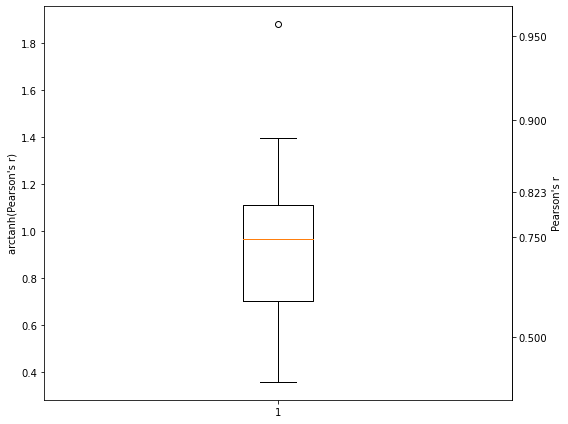

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.boxplot(corr_df.pearsons_r_fisher)
ax.set_ylabel("arctanh(Pearson's r)")
secax = ax.secondary_yaxis('right', functions=(np.tanh, np.arctanh))
secax.set_ylabel("Pearson's r")
secax.set_yticks([-0.5, 0, 0.5, 0.75, 0.823, 0.9, 0.95, 0.99]);
ax.set_xlabel("")
plt.tight_layout()

In [ ]:
np.tanh(corr_df["pearsons_r_fisher"].mean())

0.7364018950505071

In [ ]:
np.tanh(corr_df["pearsons_r_fisher"].std())

0.3473885964752639